In [ ]:
import pandas as pd
import numpy as np
import os
import copy
from sklearn.metrics  import adjusted_rand_score
import time
from metrics import frigui_index, fuzzy_to_crisp
from algorithms.state_of_the_art_algorithms import  FuzzyDoubleKmeans, WFDK
from algorithms.kernel_fuzzy_coclustering import GKFDK, WGKFDK
from algorithms.double_subspace_coclustering import DWGKFDK
import seaborn as sns
import matplotlib.pyplot as plt
from data_generation import synthetic_dataset


In [4]:
def get_metrics(y, partition):
    metrics = np.full(2,np.nan)
    y_hat = fuzzy_to_crisp(partition)
    metrics[0] = adjusted_rand_score(y, y_hat)
    metrics[1] = frigui_index(partition,y)
    return metrics

In [5]:
def display_average(averages, stds):
    n,p = averages.shape
    row_names = list(averages.index)
    col_names = list(averages.columns)
    averages = round(averages,2)
    stds = round(stds,2)
    rs = pd.DataFrame(np.zeros((n,p)))
    for i in range(n):
        for j in range(p):
            avg = averages.iloc[i,j]
            sd = stds.iloc[i,j]
            fnl = str(avg)+ ' (' + str(sd) + ')'
            rs.iloc[i,j] = fnl
    
    rs.index = row_names
    rs.columns = col_names
    return rs

def read_simulation(path, methods, metrics, results_columns = False):
    n1 = len(methods)
    n2 = len(metrics)
    rs = pd.DataFrame( np.zeros((n1, n2)), index=methods, columns=metrics)
    avrs = pd.DataFrame( np.zeros((n1, n2)), index=methods, columns=metrics)
    stds = pd.DataFrame( np.zeros((n1, n2)), index=methods, columns=metrics)
    for i in range(n1):
        method = methods[i]
        if results_columns == True:
            path_final = os.path.join(path, method, 'results_variables.txt')
        else:
            path_final = os.path.join(path, method, 'results_objects.txt')

        X = pd.read_csv(path_final, index_col=0)
        X = X.loc[:,metrics]
        avrs.loc[method,:] = X.mean()
        stds.loc[method,:] = X.std()
    avrs = avrs.applymap(lambda x: f"{x:.3f}")
    stds = stds.applymap(lambda x: f"{x:.3f}")
    return display_average(averages=avrs, stds=stds)

    

In [6]:
def MC_simulation(model = None, n_rep = 100, N = 100, P = 100, path = None, name = None, random_state = 26, save_weights = False):
    metrics = ['ARI', 'FRG']
    results_rows = pd.DataFrame(np.zeros((n_rep,7)), columns=metrics)
    results_cols = pd.DataFrame(np.zeros((n_rep,7)), columns=metrics)
    if save_weights == True:
        rows_weights = pd.DataFrame(np.zeros((n_rep,N)), columns=[f'O{i}' for i in range(1, (N+1))])
        cols_weights = pd.DataFrame(np.zeros((n_rep,P)), columns=[f'V{j}' for j in range(1, (P+1))])
    for i in range(n_rep):
        seed = random_state + i
        X, yr, yc = synthetic_dataset(N = N, P = P, random_state= seed)

        mdl = copy.deepcopy(model)
        time_initial = time.time() 
        fitted_model = mdl.fit(X = X, random_state = seed) # training step
        time_final = time.time()
        dt = time_final - time_initial
        results_rows.loc[i,:] = get_metrics(y=yr, partition=fitted_model.U)
        results_cols.loc[i,:] = get_metrics(y=yc, partition=fitted_model.V)
        if save_weights == True:
            rows_weights.loc[i,:] = fitted_model.object_weights
            cols_weights.loc[i,:] = fitted_model.variable_weights
        print(f"{name}: {i+1}/{n_rep}", end='\r')

    path_1 = os.path.join(path, name)

    if not os.path.exists(path_1):
        os.makedirs(path_1, exist_ok=True)
    
    path_rows = os.path.join(path_1, 'results_objects.txt')
    path_cols = os.path.join(path_1, 'results_variables.txt')

    results_rows.to_csv(path_rows, header=True, index=True)
    results_cols.to_csv(path_cols, header=True, index=True)

    if save_weights == True:
        path_wo = os.path.join(path_1, 'weights_objects.txt')
        path_wv = os.path.join(path_1, 'weights_variables.txt')
        rows_weights.to_csv(path_wo, header=True, index=True)
        cols_weights.to_csv(path_wv, header=True, index=True)

    

In [7]:
X,y,yc = synthetic_dataset(N=100, P=100, random_state=27)

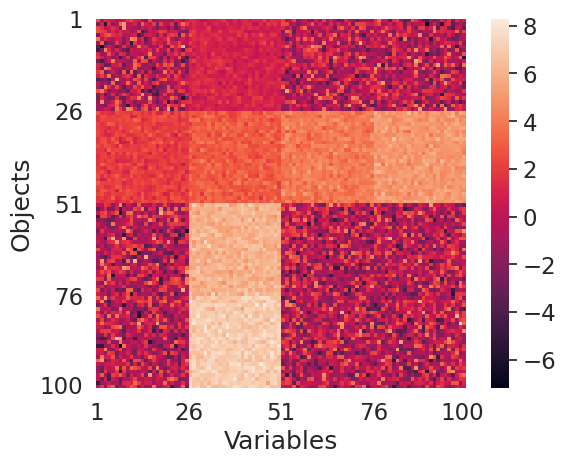

In [9]:

# Posições e rótulos desejados
tick_positions = [0, 25, 50, 75, 99]  # Índices começam do 0 no Python
tick_labels = [1, 26, 51, 76, 100]  # Os rótulos desejados

sns.set(font_scale=1.5)
# Criando o heatmap
sns.heatmap(X, square=True,  xticklabels=False, yticklabels=False)  

# Ajustando manualmente os ticks
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.yticks(ticks=tick_positions, labels=tick_labels)
plt.xlabel("Variables")
plt.ylabel("Objects")

plt.show()


In [ ]:
path = 'results_simulation/synthetic'
sig2_co = 11.018


fdk = FuzzyDoubleKmeans(K=4, H=4, m=1.0112, n=1.0201, n_init=50)
MC_simulation(model=fdk, n_rep=100, N=100, P=100, path=path, name = 'FDK', random_state=26)

wfdk = WFDK(K=4, H=4, m=1.0547, n=1.0152, beta=1.2199, n_init=50)
MC_simulation(model=wfdk, n_rep=100, N=100, P=100, path=path, name = 'WFDK', random_state=26)

gkfdk = GKFDK(K=4, H=4, m=1.2447, n=1.0190, sigma2=sig2_co, n_init=50)
MC_simulation(model=gkfdk, n_rep=100, N=100, P=100, path=path, name = 'GKFDK', random_state=26)

wgkfdk = WGKFDK(K=4, H=4, m=1.0583, n=1.0112, sigma2=sig2_co, n_init=50)
MC_simulation(model=wgkfdk, n_rep=100, N=100, P=100, path=path, name = 'WGKFDK', random_state=26)

dwgkfdk = DWGKFDK(K=4, H=4, m=1.1130, n=1.0181, sigma2=sig2_co, n_init=50)
MC_simulation(model=dwgkfdk, n_rep=100, N=100, P=100, path=path, name = 'DWGKFDK', random_state=26, save_weights=True)

In [12]:
path = 'results_synthetic'
methods = ['FDK', 'WFDK', 'GKFDK', 'WGKFDK', 'DWGKFDK']
metrics = ['ARI', 'FRG']
X =read_simulation(path=path, methods=methods, metrics=metrics, results_columns=False)
X

/tmp/ipykernel_54028/3572055385.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avrs = avrs.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_54028/3572055385.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stds = stds.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_54028/3572055385.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.662 (0.010)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rs.iloc[i,j] = fnl
/tmp/ipykernel_54028/3572055385.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.876 (0.003)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rs.iloc[i,j] = fnl


,ARI,FRG
FDK,0.662 (0.010),0.876 (0.003)
WFDK,0.455 (0.415),0.792 (0.158)
GKFDK,0.683 (0.139),0.849 (0.018)
WGKFDK,0.644 (0.058),0.851 (0.024)
DWGKFDK,1.000 (0.000),0.979 (0.004)


Text(0, 0.5, '$\\bar{\\theta_{i}}$')

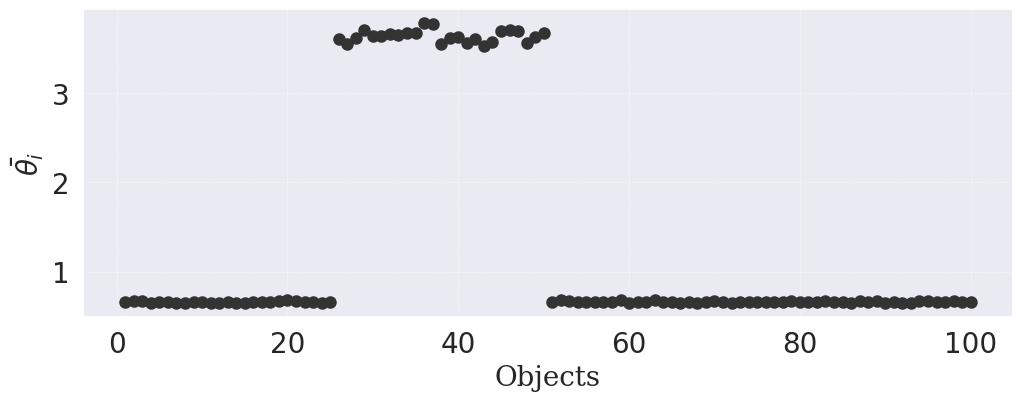

In [23]:
ow = pd.read_csv('results_synthetic/DWGKFDK/weights_objects.txt', index_col=0)

Wo = ow.mean()

v = np.arange(len(Wo)) +1

plt.figure(figsize = (12, 4))
plt.grid(alpha = 0.5,linestyle = '--', linewidth = 0.5)
plt.scatter(v,Wo, color = '#333333', linewidths=3.0)
plt.tick_params(axis='x', which='both', labelsize=20)  
plt.tick_params(axis='y', which='both', labelsize=20) 
plt.xlabel('Objects', family = 'serif', fontsize = 20)
plt.ylabel(r'$\bar{\theta_{i}}$', family = 'serif', fontsize = 20)
#plt.hlines(y = 1, xmin= 0, xmax=30, linestyles='--', color = '#333333')

Text(0, 0.5, '$\\bar{\\lambda_{j}}$')

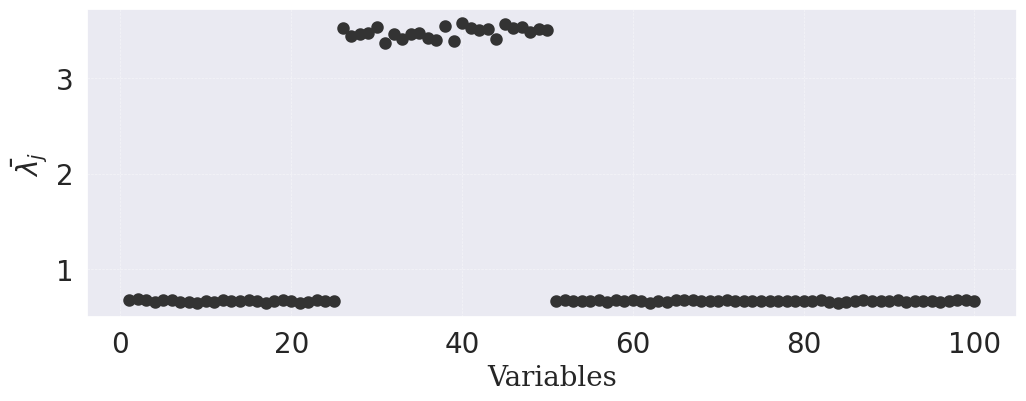

In [24]:
ov = pd.read_csv('results_synthetic/DWGKFDK/weights_variables.txt', index_col=0)

Wv = ov.mean()

v = np.arange(len(Wv)) +1

plt.figure(figsize = (12, 4))
plt.grid(alpha = 0.5,linestyle = '--', linewidth = 0.5)
plt.scatter(v,Wv, color = '#333333', linewidths=3.0)
plt.tick_params(axis='x', which='both', labelsize=20)  
plt.tick_params(axis='y', which='both', labelsize=20) 
plt.xlabel('Variables', family = 'serif', fontsize = 20)
plt.ylabel(r'$\bar{\lambda_{j}}$', family = 'serif', fontsize = 20)
#plt.hlines(y = 1, xmin= 0, xmax=30, linestyles='--', color = '#333333')

In [18]:
d = np.outer(Wo,Wv)

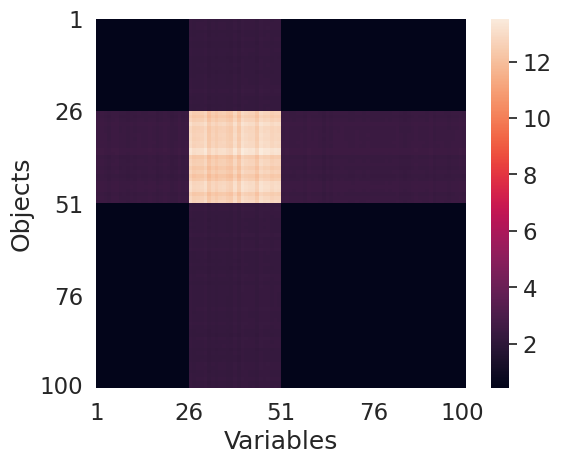

In [25]:
# Posições e rótulos desejados
tick_positions = [0, 25, 50, 75, 99]  # Índices começam do 0 no Python
tick_labels = [1, 26, 51, 76, 100]  # Os rótulos desejados

# Criando o heatmap
sns.heatmap(d, xticklabels=False, square=True, yticklabels=False)  

# Ajustando manualmente os ticks
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.yticks(ticks=tick_positions, labels=tick_labels)
plt.xlabel("Variables")
plt.ylabel("Objects")

plt.show()